In [2]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import time
from functools import partial
import pickle
import multiprocessing
import pixiedust as pxdb
import PIL
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PYTORCH
import torch as tc
import torchvision as tcvis
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as fu
# TORCH HELPERS
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import hiddenlayer as hl
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True


basepath = '/home/alk/Documents/Git/Kaggles/MNIST'
try:
    os.chdir(basepath)
    print(os.getcwd())
except NotADirectoryError:
    pass

Pixiedust database opened successfully


/home/alk/Documents/Git/Kaggles/MNIST


In [3]:
# run only when needed

datadir = os.getcwd() + '/data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = np.loadtxt(csvfile, delimiter=",", skiprows=1)
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

print(datadict.keys(), filenames)

found file: train.csv
found file: test.csv
odict_keys(['train.csv', 'test.csv']) ['train.csv', 'test.csv']


In [4]:
traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

trainlabels = traindata[:, 0].reshape(-1, 1)
traindata = traindata[:, 1:].reshape(-1, 28, 28)
testdata = testdata.reshape(-1, 28, 28)
print(traindata.shape, trainlabels.shape, testdata.shape)

(42000, 28, 28) (42000, 1) (28000, 28, 28)


In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(traindata, trainlabels, 
                                                      test_size=0.2)

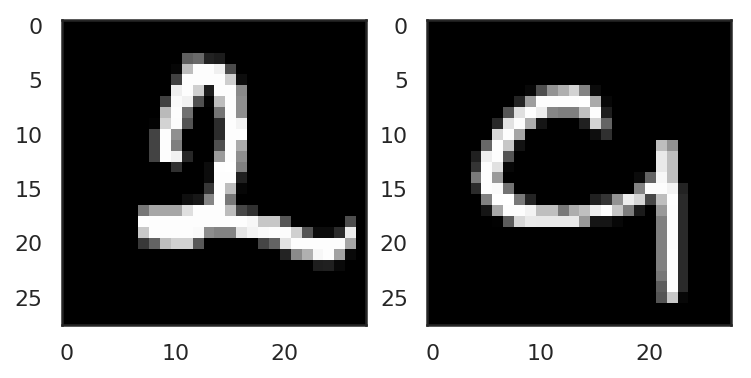

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True)
ax[0].imshow(x_train[-1, :, :], cmap='gray')
ax[1].imshow(x_valid[0, :, :], cmap='gray')

target: tensor([2])


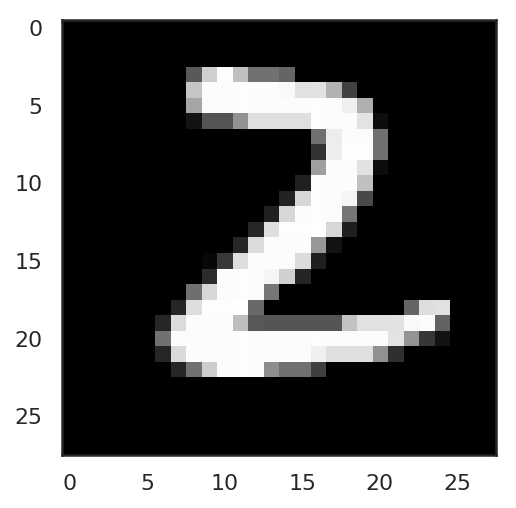

In [7]:
class NpDataset(Dataset):

    def __init__(self, x=x_train, y=y_train,
                 transforms=None):
        super().__init__()

        self.x = x
        self.y = y
        self.transform = transforms
        
    def __len__(self):

        return self.x.shape[0]

    def __getitem__(self, index):

        if self.y is not None:
            image, label = self.x[index], self.y[index]
            label = tc.from_numpy(label).type(tc.LongTensor)
        else:
            image, label = self.x[index], None
        
        # HxWxC, UINT8
        image = image.astype(np.uint8).reshape(28, 28, 1)
        # image = tc.from_numpy(image).type(tc.FloatTensor)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# test
test_set = NpDataset()
print(f'target: {test_set.__getitem__(0)[1]}')
plt.imshow(test_set.__getitem__(0)[0].reshape(28, 28), cmap='gray')

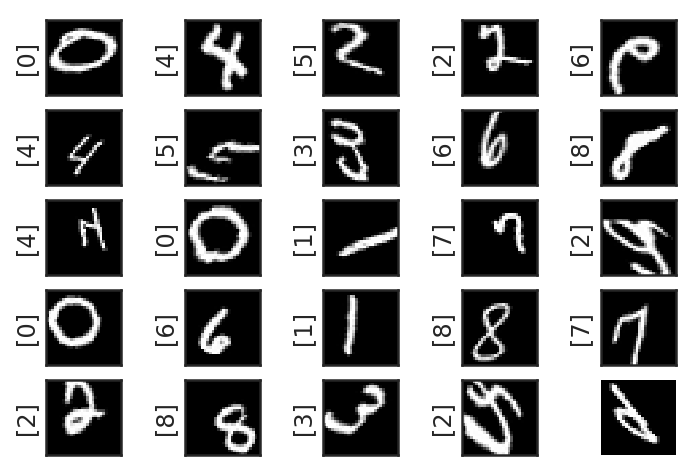

In [8]:
MNIST_train_transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.RandomVerticalFlip(0.25),
                                            transforms.RandomAffine(30, (0.15,0.15),
                                                                    (0.75,1.25), 30,
                                                                    PIL.Image.BICUBIC,0),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,),
                                                                 (0.3081,))])

MNIST_test_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.1307,),
                                                                (0.3081,))])

# test
test_set = NpDataset(transforms=MNIST_train_transform)

fig, axes = plt.subplots(5, 5, sharex=True, sharey=True)
_plots = None

for axs in axes:
    for ax in axs:
        data = test_set.__getitem__(np.random.randint(0, x_train.shape[0]))
        _plots = ax.imshow(data[0].reshape(28, 28), cmap='gray');
        _plots = ax.set_ylabel(str(data[1].numpy()))
        
_plots = plt.yticks([], [])
_plots = plt.xticks([], [])
_plots = plt.axis('off')
plt.show()

In [9]:
def my_collate(batch):
    
    data = tc.stack([item[0] for item in batch])
    target = tc.stack([item[1] for item in batch])
    
    return [data, target.view(-1)]

NN_trainloader = DataLoader(NpDataset(transforms=MNIST_train_transform),
                            batch_size=210,
                            shuffle=True,
                            collate_fn=my_collate,
                            num_workers=8,
                            pin_memory=True)

NN_testloader = DataLoader(NpDataset(x=x_valid, y=y_valid,
                                     transforms=MNIST_test_transform),
                           batch_size=210,
                           shuffle=True,
                           collate_fn=my_collate,
                           num_workers=8,
                           pin_memory=True)

# test
img, lbl = next(iter(NN_trainloader))
print(img.shape, lbl.shape)

torch.Size([210, 1, 28, 28]) torch.Size([210])


torch.Size([2, 50, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Conv2d-4           [-1, 20, 24, 24]             520
            Conv2d-5           [-1, 50, 20, 20]          25,050
            Linear-6                  [-1, 500]         625,500
            Linear-7                  [-1, 100]         100,100
            Linear-8                   [-1, 10]           1,010
Total params: 1,178,250
Trainable params: 1,178,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 4.49
Estimated Total Size (MB): 4.86
----------------------------------------------------------------
None
torch.S

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/ipykernel_launcher.py:27: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


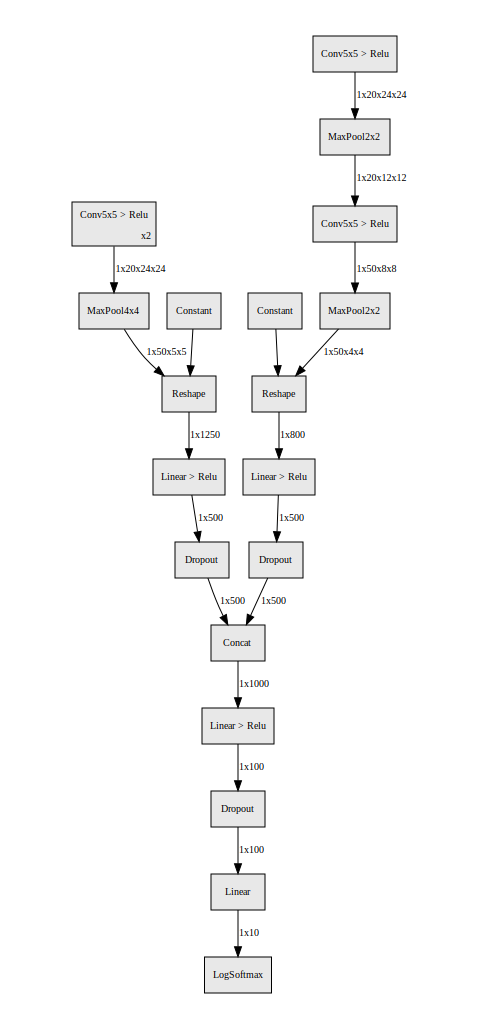

In [11]:
class MNIST_CNN(nn.Module):
    
    def __init__(self,
                 dropout_fcp=0.0):
        super(MNIST_CNN, self).__init__()
        
        self.dropout_p = dropout_fcp
        
        self.conv1a = nn.Conv2d(1, 20, 5, 1) #24
        self.conv2a = nn.Conv2d(20, 50, 5, 1) #20
        
        self.conv1b = nn.Conv2d(1, 20, 5, 1)
        self.conv2b = nn.Conv2d(20, 50, 5, 1)
        
        self.fc1a = nn.Linear(4*4*50, 500)
        self.fc1b = nn.Linear(5*5*50, 500)
        
        self.fcf1 = nn.Linear(1000,100)
        self.fcf2 = nn.Linear(100,10)
        
    def forward(self, x):
        
        x1 = fu.relu(self.conv1a(x))
        x1 = fu.max_pool2d(x1, 2, 2)
        x1 = fu.relu(self.conv2a(x1))
        x1 = fu.max_pool2d(x1, 2, 2)
        #print(x1.shape)
        x1 = x1.view(-1, 4*4*50)
        x1 = fu.relu(self.fc1a(x1))
        x1 = fu.dropout(x1, p=self.dropout_p, 
                        training=self.training)
        
        x2 = fu.relu(self.conv1a(x))
        x2 = fu.relu(self.conv2a(x2))
        x2 = fu.max_pool2d(x2, 4, 4)
        x2 = x2.view(-1, 5*5*50)
        x2 = fu.relu(self.fc1b(x2))
        x2 = fu.dropout(x2, p=self.dropout_p, 
                        training=self.training)
        
        x = tc.cat((x1, x2), 1)
        
        x = fu.relu(self.fcf1(x))
        x = fu.dropout(x, p=self.dropout_p,
                       training=self.training)
        
        x = self.fcf2(x)
        x = fu.log_softmax(x, dim=1)
        
        return x
        
# test

test_cnn = MNIST_CNN().cuda()
print(summary(test_cnn.cuda(), (1,28,28), device='cuda'))
hl.build_graph(model=test_cnn.cuda(), args=tc.randn(1,1,28,28).cuda())

In [12]:
class NN_Trainer():

    def __init__(self, model, 
                 trainloader, testloader,
                 optimizer, loss_fn, wcuda=True):
        
        self.model = model

        self.trainloader = trainloader
        self.testloader = testloader

        self.lossfn = loss_fn
        self.optimizer = optimizer
        self.metrics = {'accuracy':Accuracy(),
                        'loss':Loss(self.lossfn)}
        self.trn_records = {k:[] for k in self.metrics.keys()}
        self.val_records = {k:[] for k in self.metrics.keys()}
        self.bwise_losses = []
        
        if wcuda:
            self.wcuda, self.device = True, 'cuda'
        else:
            self.wcuda, self.device = False, 'cpu'
        
        self.run = self.__call__
    
    def __call__(self, max_epochs, log_interval):
        
        if self.wcuda:
            tc.backends.cudnn.enabled = True
            tc.cuda.empty_cache()
            
        desc = "ITERATION - loss: {:.2f}"
        pbar = tqdm(initial=0, leave=False, total=len(self.trainloader),
                    desc=desc.format(0))
        
        trainer = create_supervised_trainer(self.model,
                                            self.optimizer,
                                            self.lossfn,
                                            device=self.device)

        evaluator = create_supervised_evaluator(self.model,
                                                self.metrics,
                                                device=self.device)
        
        @trainer.on(Events.ITERATION_COMPLETED)
        def log_training_losses(engine):
            
            iter = (engine.state.iteration - 1) % len(self.trainloader) + 1
            
            if iter % log_interval == 0:
                pbar.desc = desc.format(engine.state.output)
                pbar.update(log_interval)
            
            records = engine.state.output 
            self.bwise_losses.append(records)

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(engine):
            
            pbar.refresh()
            evaluator.run(self.trainloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']
            
            tqdm_str = "Training Results - Epoch: {}  \
                        Avg accuracy: {:.2f} Avg loss: {:.2f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                       avg_accuracy, avg_nll))
            
            for k in self.metrics.keys():
                self.trn_records[k].append(metrics[k]) 

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(engine):
            evaluator.run(self.testloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']
            
            tqdm_str = "Validation Results - Epoch: {}  \
                        Avg accuracy: {:.2f} Avg loss: {:.2f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                       avg_accuracy, avg_nll))
            
            pbar.n = pbar.last_print_n = 0
            
            for k in self.metrics.keys():
                self.val_records[k].append(metrics[k]) 
        
        trainer.run(self.trainloader, max_epochs)
        pbar.close()
        
    def plot(self, prefix='Base'):
        
        fig = plt.figure(figsize=(12,6))
        ax = plt.subplot(111)
        ax2 = ax.twiny()
        plt.rc('grid', linestyle="--", color='gray')
        plt.minorticks_on()
        
        plots = [self.trn_records['accuracy'],
                 self.trn_records['loss'],
                 self.val_records['accuracy'],
                 self.val_records['loss']]
        
        labels = ['Training Accuracy',
                  'Training Loss',
                  'Validation Accuracy',
                  'Validation Loss']
        
        colors = ['xkcd:lime', 'xkcd:green', 'xkcd:red', 'xkcd:cerise']
        linestyles = ['-', '--', '-', '--']
        markers = ['o', '+', 'x', '*']


        for series, lab, col, ls, mrk in zip(plots, labels, colors, linestyles, markers):
            ax.plot(series, marker=mrk, linewidth=1, label=lab, color=col, linestyle=ls)
            ax.set_xlabel('Epochs')

        ax2.plot(self.bwise_losses, label='Batchwise Losses', alpha=0.5,
                    color='blue', linestyle='--', linewidth=1)
        ax2.set_xlabel('Batches', color='blue')
        ax2.xaxis.set_ticks_position('bottom')
        ax2.xaxis.set_label_position('bottom')
        ax2.spines['bottom'].set_position(('axes', -0.20))

        ax.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.5),
                      ncol=1, fancybox=True)
        ax2.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.75),
                      ncol=1, fancybox=True)
        ax.grid(which='major', color='black', linestyle='--')
        ax.grid(which='minor', color='gray', linestyle=':')
        plt.title(label=f'Model: {prefix}', loc='center')
  
        return fig

Training Results - Epoch: 1                          Avg accuracy: 0.81 Avg loss: 0.60
Validation Results - Epoch: 1                          Avg accuracy: 0.95 Avg loss: 0.19
Training Results - Epoch: 2                          Avg accuracy: 0.89 Avg loss: 0.36
Validation Results - Epoch: 2                          Avg accuracy: 0.97 Avg loss: 0.11
Training Results - Epoch: 3                          Avg accuracy: 0.91 Avg loss: 0.29
Validation Results - Epoch: 3                          Avg accuracy: 0.98 Avg loss: 0.08
Training Results - Epoch: 4                          Avg accuracy: 0.92 Avg loss: 0.25
Validation Results - Epoch: 4                          Avg accuracy: 0.97 Avg loss: 0.09
Training Results - Epoch: 5                          Avg accuracy: 0.93 Avg loss: 0.22
Validation Results - Epoch: 5                          Avg accuracy: 0.98 Avg loss: 0.07
Training Results - Epoch: 6                          Avg accuracy: 0.93 Avg loss: 0.21
Validation Results - Epoch: 6    

Validation Results - Epoch: 47                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 48                          Avg accuracy: 0.97 Avg loss: 0.08
Validation Results - Epoch: 48                          Avg accuracy: 0.99 Avg loss: 0.03
Training Results - Epoch: 49                          Avg accuracy: 0.97 Avg loss: 0.08
Validation Results - Epoch: 49                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 50                          Avg accuracy: 0.97 Avg loss: 0.09
Validation Results - Epoch: 50                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 51                          Avg accuracy: 0.97 Avg loss: 0.09
Validation Results - Epoch: 51                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 52                          Avg accuracy: 0.97 Avg loss: 0.08
Validation Results - Epoch: 52                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - E

Training Results - Epoch: 94                          Avg accuracy: 0.98 Avg loss: 0.07
Validation Results - Epoch: 94                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 95                          Avg accuracy: 0.98 Avg loss: 0.07
Validation Results - Epoch: 95                          Avg accuracy: 0.99 Avg loss: 0.03
Training Results - Epoch: 96                          Avg accuracy: 0.98 Avg loss: 0.07
Validation Results - Epoch: 96                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 97                          Avg accuracy: 0.98 Avg loss: 0.07
Validation Results - Epoch: 97                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 98                          Avg accuracy: 0.98 Avg loss: 0.06
Validation Results - Epoch: 98                          Avg accuracy: 0.99 Avg loss: 0.04
Training Results - Epoch: 99                          Avg accuracy: 0.98 Avg loss: 0.07
Validation Results - E

AttributeError: 'NN_Trainer' object has no attribute 'logging'

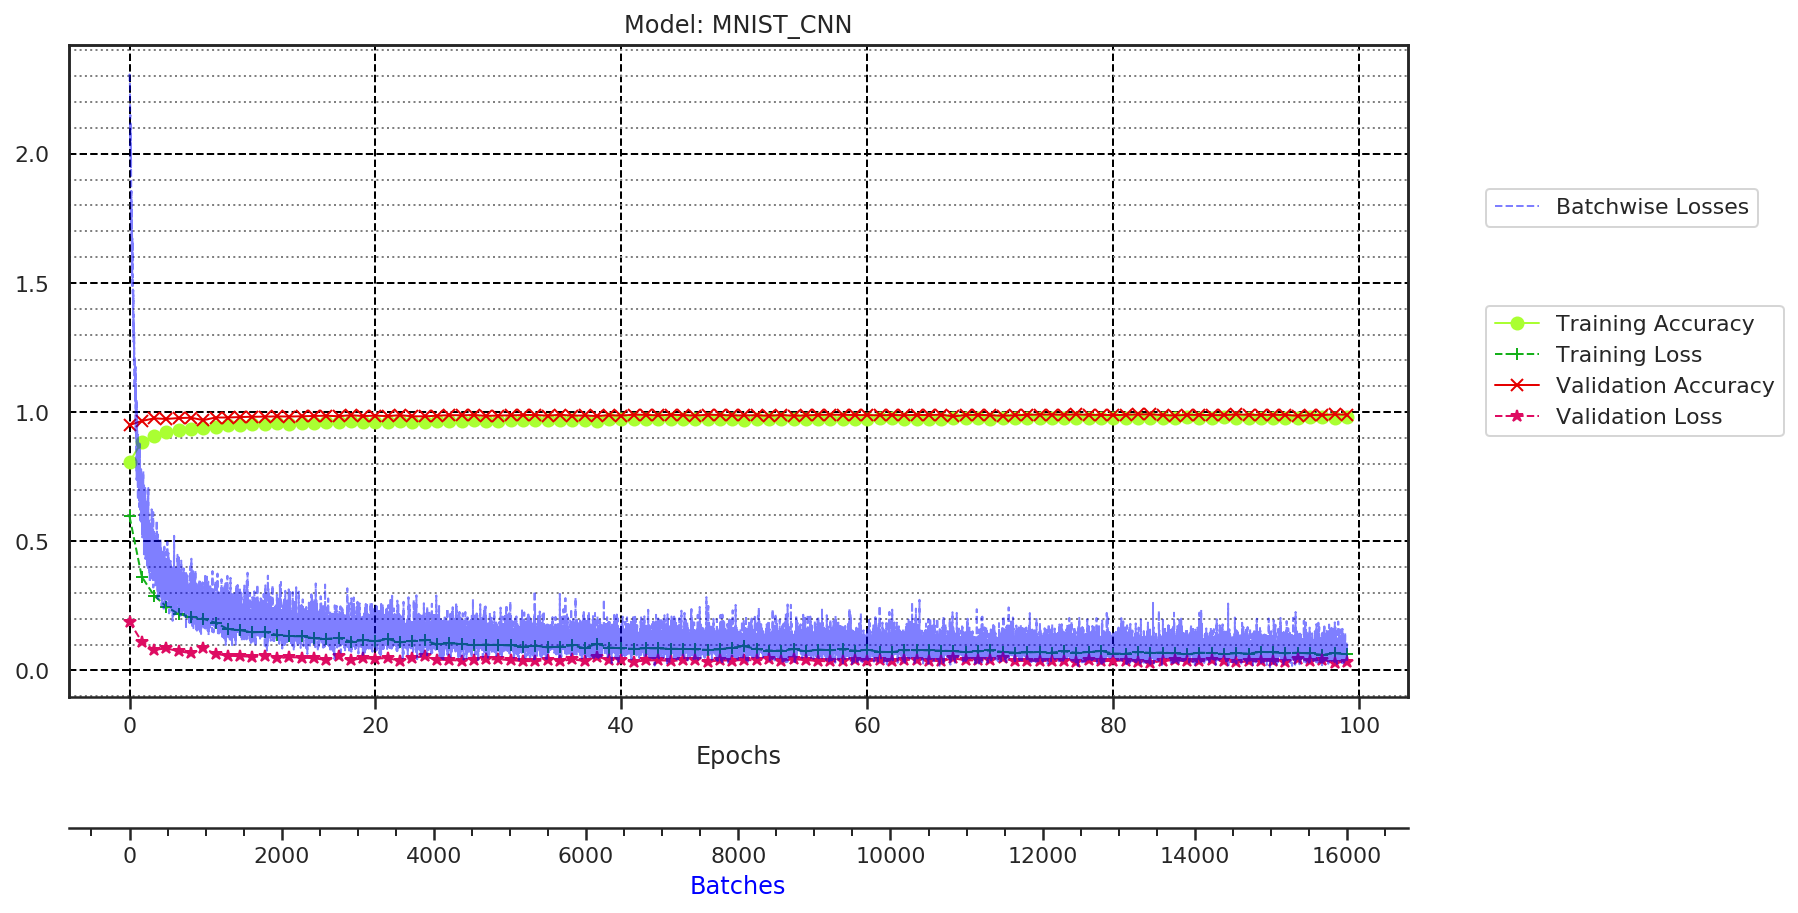

In [11]:
ModelMNIST = MNIST_CNN(dropout_fcp=0.25).cuda()
optimizer = optim.Adam(ModelMNIST.parameters(), lr=0.001)
loss_fn = fu.nll_loss

TrainMNIST = NN_Trainer(ModelMNIST, NN_trainloader, 
                        NN_testloader, optimizer, loss_fn)

TrainMNIST(100, log_interval=1)
TrainMNIST.plot('MNIST_CNN')